# Detecting credit card fraud: improving performance with Deep Learning
----

In this project, we predict instances of credit card fraud using different models. The objective is of course to correctly detect all fraudulent transactions. We use the following models:
- Logistic Regression,
- Random Forest,
- Deep Learning approach: 5-layer Neural Network built with the Keras framework.

The dataset we use is [available here](https://www.kaggle.com/mlg-ulb/creditcardfraud) on the Kaggle website. It contains 284,807 transactions made in September 2013 by European cardholders.

In the first part of this project, we only use a subset of this dataset (21,693 transactions). After having built and tested our Deep Learning model on this subset, we make use of the full dataset to improve our Neural Network's performance.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
# loading the dataset
df= pd.read_csv('fraud_data.csv')
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,1.176563,0.323798,0.536927,1.047002,-0.368652,-0.728586,0.084678,-0.069246,-0.266389,0.155315,...,-0.109627,-0.341365,0.057845,0.499180,0.415211,-0.581949,0.015472,0.018065,4.67,0
1,0.681109,-3.934776,-3.801827,-1.147468,-0.735540,-0.501097,1.038865,-0.626979,-2.274423,1.527782,...,0.652202,0.272684,-0.982151,0.165900,0.360251,0.195321,-0.256273,0.056501,912.00,0
2,1.140729,0.453484,0.247010,2.383132,0.343287,0.432804,0.093380,0.173310,-0.808999,0.775436,...,-0.003802,0.058556,-0.121177,-0.304215,0.645893,0.122600,-0.012115,-0.005945,1.00,0
3,-1.107073,-3.298902,-0.184092,-1.795744,2.137564,-1.684992,-2.015606,-0.007181,-0.165760,0.869659,...,0.130648,0.329445,0.927656,-0.049560,-1.892866,-0.575431,0.266573,0.414184,62.10,0
4,-0.314818,0.866839,-0.124577,-0.627638,2.651762,3.428128,0.194637,0.670674,-0.442658,0.133499,...,-0.312774,-0.799494,-0.064488,0.953062,-0.429550,0.158225,0.076943,-0.015051,2.67,0


In [3]:
df.shape

(21693, 30)

----
## Features exploration
The available features include:
- confidential variables **V1** to **V28** obtained from a PCA transformation,
- **Amount** of the transaction.

The target is stored in the **Class** column (where 1 represents an instance of fraud and 0 corresponds to a non-fraudulent transaction).

Because they are the result of a PCA transformation, features **V1** to **V28** probably do not need any more preprocessing. Let's plot their distributions.

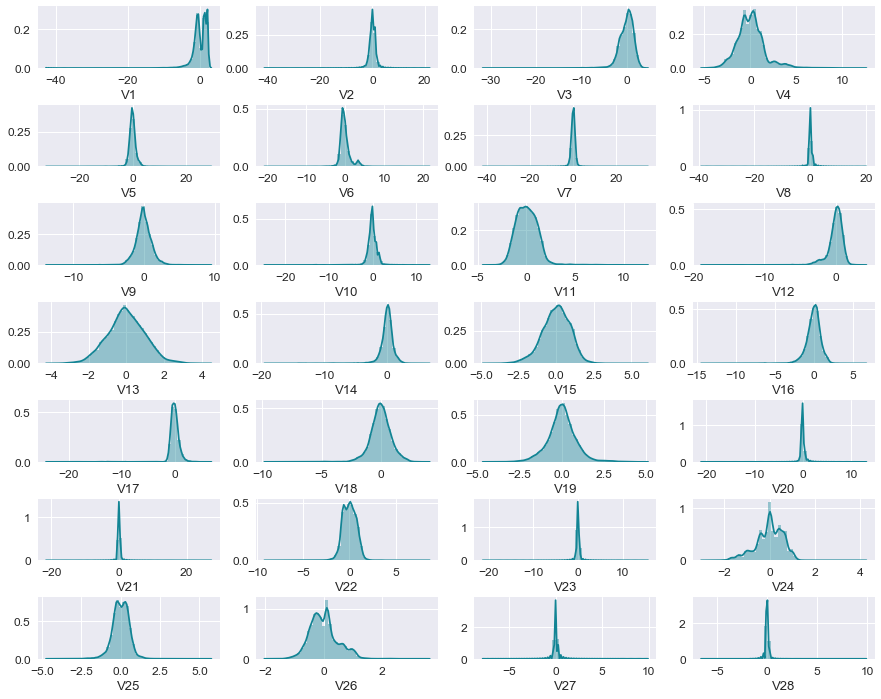

In [4]:
# generating a list of features
features_list= list(df.columns.values)
del features_list[-1]

# plotting distributions
sns.set(font_scale=1.2)
fig= plt.figure(figsize=(15,12))
fig.subplots_adjust(hspace=0.6, wspace=0.2)
for i in range(1,len(features_list)):
    ax= fig.add_subplot(7,4,i)
    sns.distplot(df[features_list[i-1]], color="#128494")

On the contrary, the **Amount** feature probably needs scaling.

In [5]:
# quick statistics corresponding to the Amount feature
df["Amount"].describe()

count    21693.000000
mean        86.776247
std        235.644479
min          0.000000
25%          5.370000
50%         21.950000
75%         76.480000
max       7712.430000
Name: Amount, dtype: float64

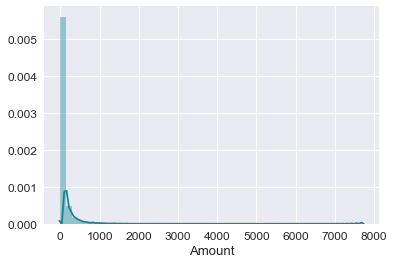

In [6]:
# visualising the distribution of the Amount feature
sns.set(font_scale=1.2)
sns.distplot(df["Amount"], color="#128494")

Indeed, **Amount** values vary quite a lot. We can see from the statistics above that they range from 0 to 7712.43 euros, with a mean of 86.78 and a standard deviation of 235.64. The 75th percentile is 76.48.

Let's scale this feature using StandardScaler from Scikit-learn to have all values between 0 and 1.

In [7]:
# scaling the Amount feature
scaler= StandardScaler()
df["Amount"]= scaler.fit_transform(df[["Amount"]])

# quick statistics of the scaled Amount feature
df["Amount"].describe()

count    2.169300e+04
mean     1.796378e-18
std      1.000023e+00
min     -3.682592e-01
25%     -3.454701e-01
50%     -2.751083e-01
75%     -4.369499e-02
max      3.236159e+01
Name: Amount, dtype: float64

----
## Imbalanced classes

Let's have a look at how imbalanced the classes are. It is indeed very common for fraud data to contain very few examples of fraud and a lot of non-fraud examples.

Fraud instances:  0.016410823768035772


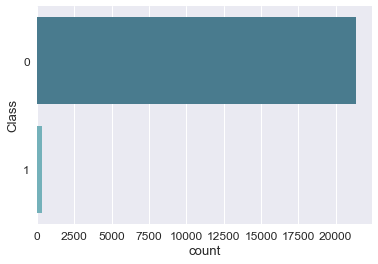

In [8]:
# visualising the number of genuine (0) vs. fraudulent transactions (1)
sns.set(font_scale=1.2)
imbalance= sns.countplot(y="Class", data=df, palette="GnBu_d")
fraud_examples= len(df[df["Class"]==1])
print("Fraud instances: ", fraud_examples/len(df))

As expected, the classes are very much imbalanced: fraudulent transactions only represent 1.64% of all transactions in this dataset. As a result, we cannot rely on accuracy as an evaluation metric for the different models that we will use. Indeed, a model that would never predict fraudulent transactions would have a very high accuracy. For the sake of the argument, let's use a Dummy Classifier to illustrate this.

In [9]:
# splitting the dataset
X= df.iloc[:,:-1]
y= df.iloc[:,-1]
X_train, X_test, y_train, y_test= train_test_split(X, y, random_state=1)

# double-checking comparable class representation in both subsets
train_proportion= len(y_train[y_train==1])/len(y_train)
test_proportion= len(y_test[y_test==1])/len(y_test)
print("Fraud instances in the training set: {:.4f} vs. test set: {:.4f}".format(train_proportion, test_proportion))

# dummy classifier
dummy= DummyClassifier(strategy="most_frequent").fit(X_train, y_train)
print("Dummy Classifier accuracy: ", dummy.score(X_test, y_test))

Fraud instances in the training set: 0.0162 vs. test set: 0.0170
Dummy Classifier accuracy:  0.983038348083


By predicting non-fraud every time, the Dummy Classifier has 98.3% accuracy. Therefore, accuracy is not an approriate metric for this dataset. Instead, we will use the $F_1$ score.

Note that, in the case of the Dummy Classifier, trying to calculate the $F_1$ score will produce a warning because the model doesn't predict any instances of fraud. The $F_1$ score will be set to 0.

In [10]:
# F1 score of the Dummy Classifier
print("Dummy Classifier F1 score: ", f1_score(y_test, dummy.predict(X_test)))

Dummy Classifier F1 score:  0.0


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


----
## Logistic Regression model
This model is very often used as a benchmark. Let's train it and calculate its $F_1$ score.

In [11]:
# Logistic Regression model with default parameters
logreg= LogisticRegression().fit(X_train, y_train)
logreg_f1= f1_score(y_test, logreg.predict(X_test))
print("Logistic Regression F1 score: ", logreg_f1)

Logistic Regression F1 score:  0.877192982456


With default parameters, the Logistic Regression model gets an $F_1$ score of 87.72% on the test set. Let's try and improve this score by tuning some parameters, namely the type of penalty and the value of C. To do this, we use GridSearchCV. Let's also plot the obtained $F_1$ scores on a heatmap for easy visualisation.

All F1 scores:
 [[ 0.77334498  0.87341772]
 [ 0.87019733  0.88546771]
 [ 0.8651704   0.86632529]
 [ 0.86881163  0.86881163]]


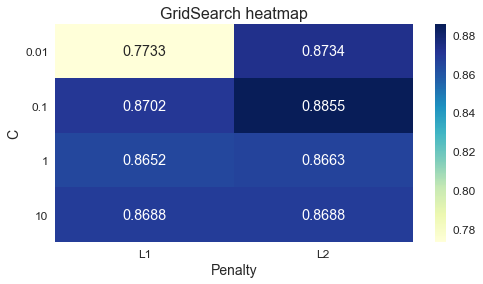

In [12]:
# using GridSearchCV to tune the penalty and C
logreg2= LogisticRegression()
grid_values= {"penalty": ["l1", "l2"], "C": [0.01, 0.1, 1, 10]}
grid_clf= GridSearchCV(logreg2, param_grid=grid_values, scoring="f1", return_train_score=True)
grid_clf.fit(X_train, y_train)
results_dict= grid_clf.cv_results_
print("All F1 scores:\n", results_dict["mean_test_score"].reshape(4,2))

# plotting all scores on a heatmap
plt.figure(figsize=(8, 4))
sns.set(font_scale=1.2)
sns.heatmap(results_dict["mean_test_score"].reshape(4,2), xticklabels=['L1','L2'], yticklabels=[0.01, 0.1, 1, 10], \
            annot=True, fmt='.4g', cmap="YlGnBu")
plt.yticks(rotation=0)
plt.xlabel('Penalty', fontsize=14)
plt.ylabel('C', fontsize=14)
plt.title('GridSearch heatmap', fontsize=16)
plt.show()

Using a GridSearch approach, the highest $F_1$ score we obtain is 88.55% on the test set, with C=0.1 and an L2 penalty.

----
## Random Forest Classifier
Because they rely the combination of multiple 'weak' learners, ensemble methods usually perform well. A Random Forest model combines several decision trees and is less likely to overfit than a single decision tree model.

We'll start by training a Random Forest Classifier with default parameters.

In [13]:
# Random Forest model with default parameters
rf= RandomForestClassifier().fit(X_train, y_train)
rf_f1= f1_score(y_test, rf.predict(X_test))
print("Random Forest F1 score: ", rf_f1)

Random Forest F1 score:  0.870588235294


With default parameters, the Random Forest Classifier performs worse than the optimised Logistic Regression model. Again, we can use a GridSearch approach to tune its parameters.

In [14]:
# using GridSearchCV to tune parameters
rf2= RandomForestClassifier()
grid_values= {"n_estimators": [10,15], "max_depth": [3,4,5], "max_features": [15,20], "min_samples_split": [2,3]}
grid_rf= GridSearchCV(rf2, param_grid=grid_values, scoring='f1', return_train_score=True)
grid_rf.fit(X_train, y_train)
print("Best F1 score:\n", grid_rf.best_score_)

Best F1 score:
 0.892893660532


In [15]:
# Random Forest model with the highest F1 score
grid_rf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features=15, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

After parameter tuning, we obtain a Random Forest model with a $F_1$ score of 89.29%.

----
## Deep Learning approach

In the context of credit card fraud, the ideal model would correctly flag 100% of fraud instances without issuing false positives. A Deep Learning approach may prove to be more powerful than the models we have been using so far.

Let's start by creating a function that computes the $F_1$ score (we'll call it when compiling the model).

In [16]:
# function to compute the F beta score (here beta=1)
def fb_score(y_true, y_pred):
    y_pred= K.clip(y_pred, 0, 1)
    true_pos= K.sum(K.round(y_true*y_pred)) + K.epsilon() #to avoid /0
    false_pos= K.sum(K.round(K.clip(y_pred-y_true, 0, 1)))
    false_neg= K.sum(K.round(K.clip(y_true-y_pred, 0, 1)))
    precision= true_pos / (true_pos+false_pos)
    recall= true_pos / (true_pos+false_neg)
    beta=1
    fb_score= (1+beta**2) * (precision*recall) / (beta**2*precision + recall + K.epsilon())
    return fb_score

We take advantage of the Keras framework to build a 5-layer Neural Network consisting of densely connected layers and dropout layers for regularisation. The activation function of the final layer is the sigmoid function.

In [17]:
# building the model
model= Sequential()
model.add(Dense(64, activation='relu', input_shape=(29,)))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[fb_score])

In [18]:
# learning
model.fit(X_train, y_train, epochs=5, batch_size=16)

Epoch 1/5
16269/16269 [==============================] - 3s 187us/step - loss: 0.0901 - fb_score: 0.8287
Epoch 2/5
16269/16269 [==============================] - 2s 151us/step - loss: 0.0313 - fb_score: 0.9275
Epoch 3/5
16269/16269 [==============================] - 2s 153us/step - loss: 0.0264 - fb_score: 0.9352
Epoch 4/5
16269/16269 [==============================] - 2s 150us/step - loss: 0.0222 - fb_score: 0.9392
Epoch 5/5
16269/16269 [==============================] - 2s 151us/step - loss: 0.0201 - fb_score: 0.9449


In [19]:
# using X_test to predict instances of fraud and computing the F1 score
f1_score= model.evaluate(X_test, y_test, batch_size=1)
print("5-layer Neural Network F1 score: ", f1_score[1])

5424/5424 [==============================] - 6s 1ms/step
5-layer Neural Network F1 score:  0.996497050848


On the test set, our Neural Network model achieves an $F_1$ score of 99.65%, which is a huge improvement from the previous models. 

It can be useful to have a look at the false positives and false negatives numbers.

In [20]:
# making predictions from X_test and rounding the obtained probabilities
y_pred= model.predict(X_test)
y_pred= np.round(y_pred, decimals=0)

# creating a dataframe to compare y_test and y_pred
pred_df= pd.DataFrame({"Predictions": y_pred.flatten(), "Truth": y_test})
pred_df.head()

,Predictions,Truth
11930,0.0,0
21243,0.0,0
17316,0.0,0
1792,0.0,0
5291,0.0,0


In [21]:
# false negatives
num_false_neg= len(pred_df[(pred_df["Predictions"]==0) & (pred_df["Truth"]==1)])
print("False negatives: ", num_false_neg/len(y_test))

# false positives
num_false_pos= len(pred_df[(pred_df["Predictions"]==1) & (pred_df["Truth"]==0)])
print("False positives: ", num_false_pos/len(y_test))

# correct predictions (true positives + true negatives)
num_correct= len(pred_df[(pred_df["Predictions"]==1) & (pred_df["Truth"]==1)]) + \
                len(pred_df[(pred_df["Predictions"]==0) & (pred_df["Truth"]==0)])
print("Correct predictions: ", num_correct/len(y_test))

False negatives:  0.0031342182890855457
False positives:  0.0003687315634218289
Correct predictions:  0.9964970501474927


Our model issues 0.31% of false negatives and 0.04% of false positives. Its predictions are correct at 99.65%.

----
# Improving performance with more data
One of the strengths of Deep Learning is that training a model with more data often improves performance. Let's load the full credit card transactions dataset and re-train our Neural Network with it.

In [23]:
# loading the complete dataset from Kaggle
full_df= pd.read_csv("fraud_data_full.csv")
full_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [24]:
full_df.shape

(284807, 30)

In [25]:
# scaling the Amount feature
scaler= StandardScaler()
full_df["Amount"]= scaler.fit_transform(full_df[["Amount"]])

# splitting the dataset
X= full_df.iloc[:, :-1]
y= full_df.iloc[:, -1]
X_train, X_test, y_train, y_test= train_test_split(X, y, random_state=1, test_size=0.05)

In [26]:
# fitting the model with the new data
model.fit(X_train, y_train, epochs=5, batch_size=64)

Epoch 1/5
270566/270566 [==============================] - 11s 40us/step - loss: 0.0043 - fb_score: 0.9519
Epoch 2/5
270566/270566 [==============================] - 11s 40us/step - loss: 0.0042 - fb_score: 0.9525
Epoch 3/5
270566/270566 [==============================] - 11s 40us/step - loss: 0.0040 - fb_score: 0.9531
Epoch 4/5
270566/270566 [==============================] - 11s 40us/step - loss: 0.0037 - fb_score: 0.9587
Epoch 5/5
270566/270566 [==============================] - 11s 41us/step - loss: 0.0037 - fb_score: 0.9579


In [27]:
# using the new X_test to predict instances of fraud and computing the F1 score
f1_score= model.evaluate(X_test, y_test, batch_size=1)
print("Neural Network trained with bigger dataset F1 score: ", f1_score[1])

14241/14241 [==============================] - 16s 1ms/step
Neural Network trained with bigger dataset F1 score:  0.999368022035


Training the Neural Network with more data indeed leads to an improvement in performance: the model now achieves an $F_1$ score of 99.94%.
Let's have a look at the false negatives and false positives numbers issued on the test set when the model is trained with a lot more data.

In [28]:
# making predictions from X_test and rounding the obtained probabilities
y_pred= model.predict(X_test)
y_pred= np.round(y_pred, decimals=0)

# creating a dataframe to compare y_test and y_pred
pred_df= pd.DataFrame({"Predictions": y_pred.flatten(), "Truth": y_test})
pred_df.head()

# false negatives
num_false_neg= len(pred_df[(pred_df["Predictions"]==0) & (pred_df["Truth"]==1)])
print("False negatives: ", num_false_neg/len(y_test))

# false positives
num_false_pos= len(pred_df[(pred_df["Predictions"]==1) & (pred_df["Truth"]==0)])
print("False positives: ", num_false_pos/len(y_test))

# correct predictions (true positives + true negatives)
num_correct= len(pred_df[(pred_df["Predictions"]==1) & (pred_df["Truth"]==1)]) + \
                len(pred_df[(pred_df["Predictions"]==0) & (pred_df["Truth"]==0)])
print("Correct predictions: ", num_correct/len(y_test))

False negatives:  0.00035109893968120215
False positives:  0.00028087915174496175
Correct predictions:  0.9993680219085739


From the results above, we can tell that the number of false positives is now slightly lower (0.03% now vs. 0.04% before). More importantly, we see that training the Neural Network with more data leads to a significant improvement in terms of false negatives. Indeed, the model now issues 0.04% of false negatives (down from 0.31% when the model was trained with the short version of the dataset). This means that our model is now able to successfully detect more fraudulent transactions which it may have missed before.


----
## Conclusion


In this project, we have used different models to detect credit card fraud. A 5-layer Neural Network achieved the best score by far, and its performance was further improved by training it with more data. In particular, using a bigger dataset led to a lower number of false negatives. In the case of this dataset, a Deep Learning approach was therefore much more efficient than the other models at detecting fraudulent transactions.